# 5. Compositional Tracking

This notebook demonstrates the compositional tracking capabilities in TriPoD, which allows you to track multiple chemical species through gas and dust phases including sublimation and condensation processes.

TriPoD extends the basic dust evolution framework to include:
- Multiple chemical components with distinct properties
- Gas and dust phases for each component
- Sublimation and condensation processes

## Theory

### Gas

This means under the hood Tripod evolves all the gas components and sums them up to get the total gas surface density. We do this following the works of ([Pavlyuchenkov and C. P. Dullemond 2007](http://www.aanda.org/10.1051/0004-6361:20077317)) who showed that we can decompose the evolution of gas disk into its components $i$ as follows:

\begin{equation*}
\frac{\partial \Sigma_i}{\partial t}
+ \frac{1}{R} \frac{\partial}{\partial R} (R \Sigma_i v_R)
= \frac{3}{R} \frac{\partial}{\partial R} \left[ R \nu \Sigma \frac{\partial}{\partial R} \left( \frac{\Sigma_i}{\Sigma} \right) \right].
\end{equation*}

where the velocity is given by:

\begin{equation*}
v_R = -\frac{3}{\Sigma \sqrt{R}} \frac{\partial}{\partial R} \left( \Sigma \nu \sqrt{R} \right).
\end{equation*}

and the total gas surface destiy is $\Sigma = \sum_i \Sigma_i$. 


### Dust

for active dust components we follow ([Schneider & Bitsch 2021](http://arxiv.org/abs/2105.13267)) i.e. the dust evolution can be described by if there are mutiple components present:

\begin{equation*}
\frac{\partial \Sigma_{d,i,j}}{\partial t} + \frac{1}{r} \frac{\partial}{\partial r} \left\{ r \left[ \Sigma_{d,i,j} \cdot u_{d,j} - \frac{\partial}{\partial r} \left( \frac{\Sigma_{d,i,j}}{\Sigma_{\text{gas}}} \right) \cdot \Sigma_{\text{gas}} \nu \right] \right\} = \frac{\partial \Sigma_{d,i,j}}{\partial t}\vert_{coag}
\end{equation*}

where the velocities $u_{d,j}$ are acalcualted for the total dust and $j$ refers to the mass bin (0 or 1). The bulk density of the total dust is given by:

\begin{equation*}
\rho_s = \sum_i \Sigma_i /(\sum_i \Sigma_i/\rho_{s,i})
\end{equation*}

and the coagualtion source term for each component is defiend by:

\begin{equation*}
\dot{\Sigma}_{i,0 \rightarrow 1} = \frac{\Sigma_{i,0} \Sigma_1 \sigma_{01} \Delta v_{01}}{m_1 \sqrt{2\pi(H_0^2 + H_1^2)}},
\dot{\Sigma}_{1\rightarrow 0}
= \frac{\Sigma_1 \Sigma_{1,i}\,\sigma_{11}\,\Delta v_{11}}{ m_1\,2\pi H_1^{2}}\,\mathcal{F}
\end{equation*}

where $\mathcal{F}$ is the same as in section 0. this ensures all of the species exchange mass on the same timescale as the global dust.



### Evaporation and Condensation

lastly we have to go over how the equilibration between the dust and gas phase works if we have a species that is active in both gas and dust. We follow the descrition outlined in ([Penzlin et al. 2024](http://arxiv.org/abs/2407.03199)) to describe the sublimation and condensatiion rates of each species.

the sublimation of a specific species $i$ is given by:
\begin{equation*}
\dot{\Sigma}_{S,i} =
\frac{\Sigma_d \langle 4\pi a^{2} \rangle}{\langle m_d \rangle}
N_{\mathrm{bind}}\, m_i\, f_{C,i}\, \nu_i
\exp\!\left(-\frac{E_{\mathrm{sub},i}}{T}\right)
\end{equation*}

where $f_{C,i}$ is the fraction of binding sites covered by the ice given by:

\begin{equation*}
f_{C,i} = 1 - \text{exp}\left(\frac{\Sigma_{d,i}}{\frac{\Sigma_d \langle 4\pi a^{2} \rangle}{\langle m_d \rangle}N_{\mathrm{bind} \:m_i}}\right)
\end{equation*}

and the condensation is given by:

\begin{equation*}
\dot{\Sigma}_{C,i} =
\frac{\Sigma_d \langle \pi a^{2} \rangle}{\langle m_d \rangle}
\frac{\Sigma_{g,i}}{\sqrt{2\pi}\,H}
\sqrt{\frac{8 k_B T}{\pi m_i}}\, P_{\mathrm{stick}}.
\end{equation*}

where $A=\frac{\Sigma_d \langle 4\pi a^{2} \rangle}{\langle m_d \rangle}$ is the total surface area the vapour can condense onto, $m_i$ is the molecular weight of the species, $N_{\mathrm{bind}} = 10^{15} \text{cm}^{-1}$. The material parameters $\nu_i$, and $E_{\mathrm{sub}}$ are specific to the component with a few examples given in `chem.txt` which was adapted from [drift_composition](https://github.com/rbooth200/drift_composition.git) (written by Richard Booth). We solve for these two proceses simultaneously with the hydrodynamics (of the dust and gas) and the dust growth in the implicit solver.

## Setting Up a Simulation with Components

Let's start by importing the necessary modules and creating a simulation object.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tripod
import dustpy.constants as c

# Create simulation object
sim = tripod.Simulation()

# Basic setup
sim.ini.grid.Nr = 50
sim.ini.grid.rmin = 1.0 * c.au
sim.ini.grid.rmax = 1000.0 * c.au

# Initialize the simulation
sim.initialize()

## Default Components

By default, TriPoD creates one gas component with the desired mean molecular weight and surface desity profile from the input:

In [2]:
sim.components

Group (components)
------------------
    Default      : Group (Default gas componentDefault (dust_tracer=False, gas_active=True, gas_tracer=False))
  -----

Each component can have one of several different beaviours:

-   it can be a tracer in the dust or the gas (if there are mutiple components available for gas or dust the tracer follows the global evolution i.e. the sum of the components)

- it can be active in the dust or gas and thus contributes to the golobal evolution of the corresponing field (we follow the derrivations of  ([Pavlyuchenkov and C. P. Dullemond 2007](http://www.aanda.org/10.1051/0004-6361:20077317)) for the gas and ([Schneider & Bitsch 2021](http://arxiv.org/abs/2105.13267)) for the dust

- it can be active both in  the dust and gas and will equilibrate acoording to the sublimation condesation equilibrium 


## Adding Custom Components

Let's look at how to add the different types of components to the simulation. To do this we have to call the `addcomponent_c` function after the simulation is initialized. It is called in the following way:  

`Simulation.addcomponent(name, gas_value, mu, dust_value = None ,dust_active=False,dust_tracer=False, gas_active=False, gas_tracer=False, description="",rhos=1.0)`  

- `name`: string   
Name of the new component

- `gas_value`: np.array; shape(Nr)  
suface desity of the component or value of the tracer in the gas

- `mu`: float   
mean molecular weight of component, only used when `gas_active=True`

- `dust_value`: np.array; shape(Nr,2)  
suface desity of the component or value of the tracer in the dust 

- `rhos`: float  
bulk desity of the component in the solid phase, only used when `dust_active=True`

- `description`: str  
additional information that is displayed when printing the component

The boolians controll if the component should behave like a passive tracer (`gas_tracer=True` or `dust_tracer=True`) or an active component contributing to the gas/dust evolution (`gas_active=True` or `dust_active=True`) if the component is set to active in gas and dust i.e. if `gas_active=True` and `dust_active=True` then the component will follow the evaporation/condesation evolution outlined above.

Below we show examples how to set up simulations with components for the different behaviours:

### TRACERS 

below we set up a example simualtion with a gas and dust tracer with a step function and let it be advected by the corresponding fluid

In [3]:
sim.t.snapshots = np.linspace(0,1e6*c.year,20)

tr_gas = np.ones_like(sim.grid.r)*1e-5
tr_gas[sim.grid.r<10*c.au] = 1.0
tr_dust = tr_gas[:,None]*np.ones_like(sim.dust.Sigma)
sim.addcomponent("tr_gas",tr_gas,0.32,gas_tracer=True)
sim.addcomponent("tr_dust",tr_dust,0.32,dust_value=tr_dust,dust_tracer=True)

sim.writer.datadir = "5.1_data"

In [4]:
sim.run()


TriPoD v0.0.1

Creating data directory 5.1_data.
Writing file 5.1_data/data0000.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0001.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0002.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0003.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0004.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0005.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0006.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0007.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0008.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0009.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0010.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0011.hdf5
Writing dump file 5.1_data/frame.dmp
Writing file 5.1_data/data0012.hdf5
Writing dump file 5.1_data/frame.dmp
W

In [5]:
from dustpy import hdf5writer
wrtr = hdf5writer()

In [6]:
wrtr.datadir = "5.1_data"
data = wrtr.read.all()

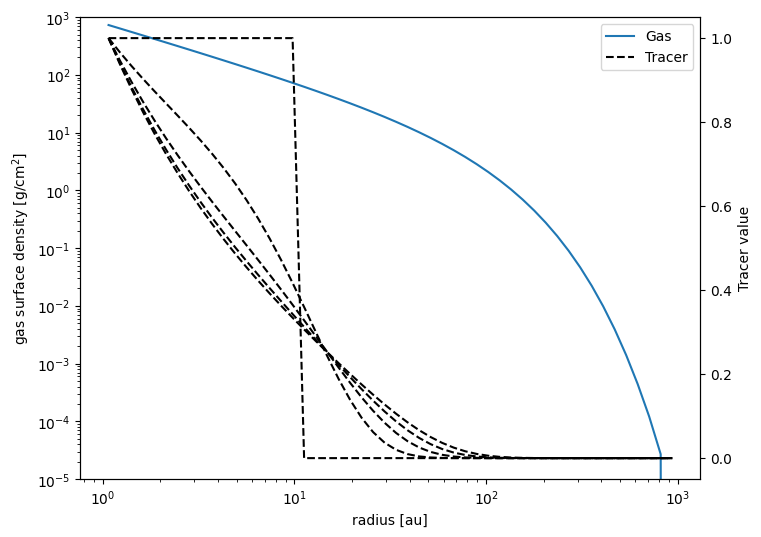

In [7]:
plt.figure(figsize=(8,6))
plt.plot(sim.grid.r/c.au, sim.components.Default.gas.Sigma, label="Gas")
plt.plot([],[],'k--',label='Tracer')
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-5, 1e3)
plt.legend()
plt.xlabel('radius [au]')
plt.ylabel(r'gas surface density [g/cm$^2$]')
ax2 = plt.twinx()
ax2.set_ylabel('Tracer value')

for t in range(len(data.t))[::4]:
    ax2.plot(sim.grid.r/c.au, data.components.tr_gas.gas.value[t,:],"k--")

And component of dust is evolved using the density bins of the small dust in `lst_tr_dust[i][:,0]` and the large dust `lst_tr_dust[i][:,1]`.

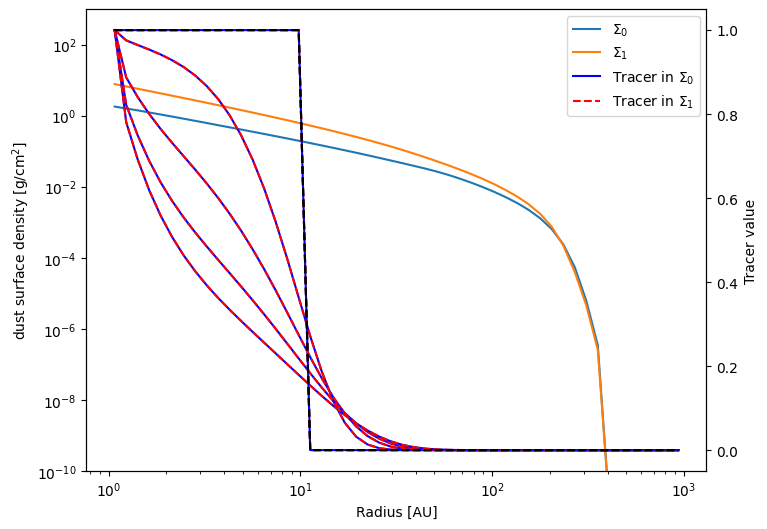

In [8]:
plt.figure(figsize=(8,6))
plt.plot(sim.grid.r/c.au, sim.dust.Sigma[:,0], label=r"$\Sigma_0$")
plt.plot(sim.grid.r/c.au, sim.dust.Sigma[:,1], label=r"$\Sigma_1$")
plt.plot([],[],'b',label=r'Tracer in $\Sigma_0$')
plt.plot([],[],'r--',label=r'Tracer in $\Sigma_1$')
plt.legend()

plt.yscale("log")
plt.xscale("log")
plt.xlabel('Radius [AU]')
plt.ylabel(r'dust surface density [g/cm$^2$]')
plt.ylim(1e-10, 1e3)
ax2 = plt.twinx()
ax2.set_ylabel('Tracer value')

for t in range(len(data.t))[::4]:
    ax2.plot(sim.grid.r/c.au, data.components.tr_dust.dust.value[t,:,0],"b" )
    ax2.plot(sim.grid.r/c.au, data.components.tr_dust.dust.value[t,:,1],"r--")

plt.plot(sim.grid.r/c.au,tr_dust,'k--',label='Initial condition')
plt.show()

### Dust component

Here, we demostrate how two different dust components will diffuse and mix, while not changing the dust profile. We assuming a separate outer dust reservoir `dust_value1` and outer reservoir `dust_value2`.

In [9]:
sim = tripod.Simulation()
sim.ini.grid.rmin = 1 * c.au
sim.ini.grid.rmax = 1000 * c.au
sim.ini.grid.Nr = 500
sim.ini.gas.SigmaRc = 100*c.au
sim.initialize()
sim.t.snapshots = np.linspace(0,1e6*c.year,20)

dust_value1 = sim.dust.Sigma.copy()
dust_value1[sim.grid.r<10*c.au] = 1e-11
dust_value2 = sim.dust.Sigma.copy()
dust_value2[sim.grid.r>10*c.au] = 1e-11
sim.addcomponent("dust1",sim.gas.SigmaFloor,1,dust_value=dust_value1 ,dust_active=True, gas_active=False, gas_tracer=False,rhos=sim.dust.rhos[0,0])
sim.addcomponent("dust2",sim.gas.SigmaFloor,1,dust_value=dust_value2 ,dust_active=True, gas_active=False, gas_tracer=False,rhos=sim.dust.rhos[0,0])

sim.writer.datadir = "5.2_data"

This is the initial dust profile. The overall dust follows a smooth profile that needs to be maintained.

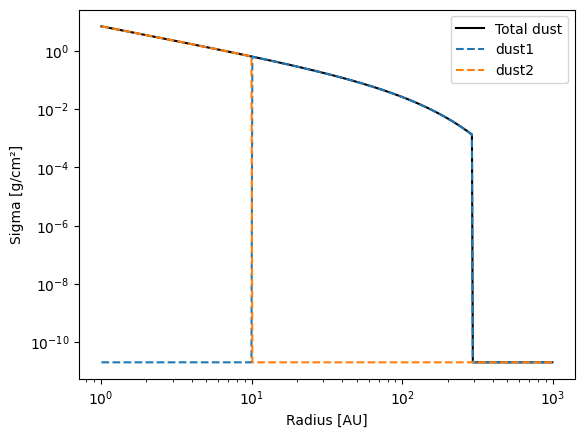

In [10]:
plt.figure()
plt.plot(sim.grid.r/c.au,sim.dust.Sigma.sum(-1),"k",label="Total dust")
plt.plot(sim.grid.r/c.au,sim.components.dust1.dust.Sigma.sum(-1),"--",label="dust1")
plt.plot(sim.grid.r/c.au,sim.components.dust2.dust.Sigma.sum(-1),"--",label="dust2")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Radius [AU]")
plt.ylabel("Sigma [g/cm²]")
plt.legend()
plt.show()

In [11]:
sim.run()


TriPoD v0.0.1

Creating data directory 5.2_data.
Writing file 5.2_data/data0000.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0001.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0002.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0003.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0004.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0005.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0006.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0007.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0008.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0009.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0010.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0011.hdf5
Writing dump file 5.2_data/frame.dmp
Writing file 5.2_data/data0012.hdf5
Writing dump file 5.2_data/frame.dmp
W

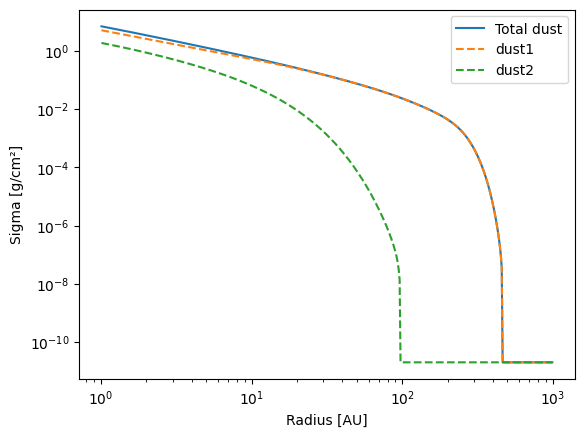

In [12]:
plt.figure()
plt.plot(sim.grid.r/c.au,sim.dust.Sigma.sum(-1),label="Total dust")


plt.plot(sim.grid.r/c.au,sim.components.dust1.dust.Sigma.sum(-1),"--" ,label="dust1")
plt.plot(sim.grid.r/c.au,sim.components.dust2.dust.Sigma.sum(-1),"--" ,label="dust2")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Radius [AU]")
plt.ylabel("Sigma [g/cm²]")
plt.legend()
plt.show()

## Evaporating and Condensating Component

If the components track molecules within a protoplanetary disc, the molecular species can transition from solids to gas and visversa through (re)sublimation. If the material is no tracer and active this will be taken into account.

In [13]:
sim_compo = tripod.Simulation()
sim_compo.ini.grid.rmin = 1 * c.au
sim_compo.ini.grid.rmax = 1000 * c.au
sim_compo.ini.grid.Nr = 500
sim_compo.ini.gas.SigmaRc = 100*c.au
sim_compo.initialize()
sim_compo.t.snapshots = np.linspace(0,1e6*c.year,20)

sim_compo.writer.datadir = "5.3_data"

dust_value=np.minimum(sim_compo.gas.Sigma*5e-3,sim_compo.dust.Sigma.sum(-1))
dust_value =  dust_value[:,None] * 0.5
# Adds bcakground dust
sim_compo.addcomponent("default_dust",sim_compo.gas.SigmaFloor,1,dust_value=sim_compo.dust.Sigma ,dust_active=True, gas_active=False, gas_tracer=False,rhos=sim_compo.dust.rhos[0,0])
#add the CO component
sim_compo.addcomponent("CO",sim_compo.gas.SigmaFloor,1,dust_value=dust_value ,dust_active=True, gas_active=True,rhos=1.)

For the sublimation the component requires additional information for each species (or the code will not work): the mean molecular weight `sim.components.SPECIES.gas.pars.mu`, the attempt frequency `sim.components.SPECIES.gas.pars.nu`, and the binding energy in Kelvin `sim.components.SPECIES.gas.pars.Tsub` (see also appendix in https://arxiv.org/pdf/2407.03199) and the bulk density of the material `sim.components.SPECIES.dust.pars.rhos`.

In [14]:
# Set CO parameters for condensation/evaporation
sim_compo.components.CO.gas.pars.mu = 28 * c.m_p
sim_compo.components.CO.gas.pars.nu = 7.0e11
sim_compo.components.CO.gas.pars.Tsub = 1180
sim_compo.components.CO.dust.pars.rhos = 1.0

#update dust internal density -> changed when adding new component
sim_compo.dust.rhos.update()

Now in the initial profile, all the CO is initialized as part of the dust component. 

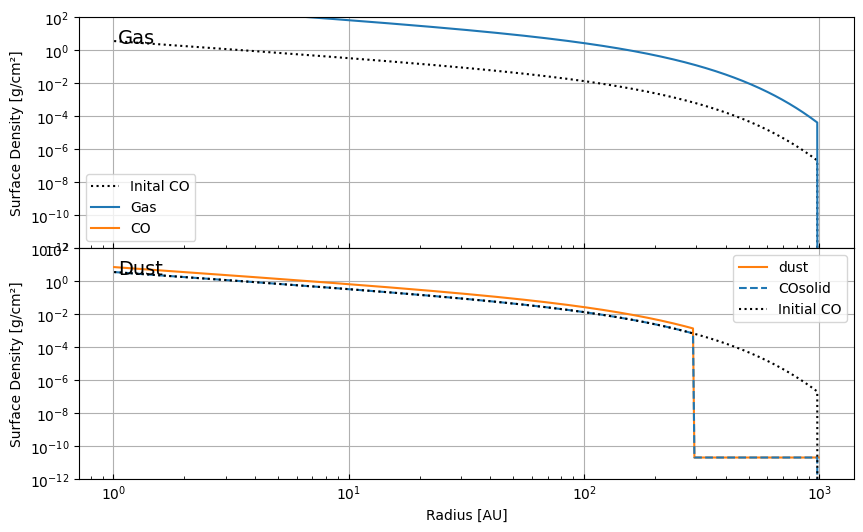

In [15]:
fg,axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(sim_compo.grid.r/c.au,sim_compo.gas.Sigma*5e-3,"k:", label="Inital CO")

axs[0].plot(sim_compo.grid.r/c.au,sim_compo.components.Default.gas.Sigma,label="Gas")
p = axs[0].plot(sim_compo.grid.r/c.au,sim_compo.components.CO.gas.Sigma,label="CO")

axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.default_dust.dust.Sigma.sum(-1),color =p[0].get_color(),label="dust")
axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.CO.dust.Sigma.sum(-1),"--",label="COsolid")


axs[1].plot(sim_compo.grid.r/c.au,sim_compo.gas.Sigma*5e-3,"k:",label='Initial CO')
axs[0].legend()
axs[1].legend()
plt.subplots_adjust(hspace=0)
axs[0].tick_params(axis='x', direction='in')
axs[1].tick_params(axis='x', direction='in')
axs[0].tick_params(axis='x', which='minor', direction='in')
axs[1].tick_params(axis='x', which='minor', direction='in')
axs[0].text(0.05, 0.95, 'Gas', transform=axs[0].transAxes, fontsize=14, verticalalignment='top')
axs[1].text(0.05, 0.95, 'Dust', transform=axs[1].transAxes, fontsize=14, verticalalignment='top')
for ax in axs:
    ax.set_xlabel('Radius [AU]')
    ax.set_ylabel('Surface Density [g/cm²]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-12, 1e2)
    ax.grid()
plt.show()

In [16]:
sim_compo.run()


TriPoD v0.0.1

Creating data directory 5.3_data.
Writing file 5.3_data/data0000.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0001.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0002.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0003.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0004.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0005.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0006.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0007.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0008.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0009.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0010.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0011.hdf5
Writing dump file 5.3_data/frame.dmp
Writing file 5.3_data/data0012.hdf5
Writing dump file 5.3_data/frame.dmp
W

In the simulation the CO will find new equilibrium between condensation and sublimation of the molecular species (CO here). This means if will the gas density will drop exponentially at the ice line, while the dust density is reshaped by the drift, back-diffusion and sublimation to a more complexe profile.

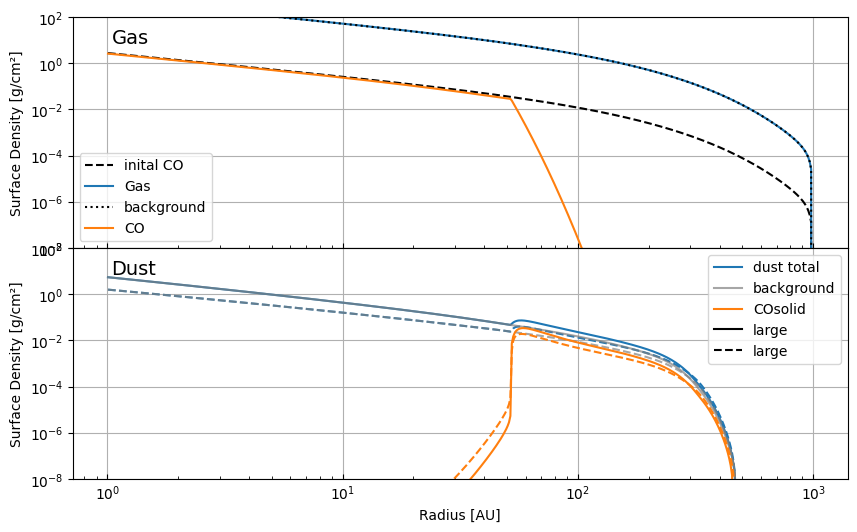

In [17]:
fg,axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(sim_compo.grid.r/c.au,sim_compo.gas.Sigma*5e-3,"k--", label="inital CO")

p1 = axs[0].plot(sim_compo.grid.r/c.au,sim_compo.gas.Sigma,label="Gas")
axs[0].plot(sim_compo.grid.r/c.au,sim_compo.components.Default.gas.Sigma,"k:",label="background")
p = axs[0].plot(sim_compo.grid.r/c.au,sim_compo.components.CO.gas.Sigma,label="CO")

axs[1].plot(sim_compo.grid.r/c.au, sim_compo.dust.Sigma[:,0],"--",color =p1[0].get_color())
axs[1].plot(sim_compo.grid.r/c.au, sim_compo.dust.Sigma[:,1],color =p1[0].get_color(),label="dust total")

axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.default_dust.dust.Sigma[:,0],"--",color ="gray", alpha =0.7)
axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.default_dust.dust.Sigma[:,1],color ="gray", alpha =0.7,label="background")

axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.CO.dust.Sigma[:,0],"--",color =p[0].get_color())
axs[1].plot(sim_compo.grid.r/c.au, sim_compo.components.CO.dust.Sigma[:,1],color =p[0].get_color(),label="COsolid")

axs[1].plot([],[], label='large', color="k")
axs[1].plot([],[], "k--",label='large')
axs[0].legend()
axs[1].legend()
plt.subplots_adjust(hspace=0)
axs[0].tick_params(axis='x', direction='in')
axs[1].tick_params(axis='x', direction='in')
axs[0].tick_params(axis='x', which='minor', direction='in')
axs[1].tick_params(axis='x', which='minor', direction='in')
axs[0].text(0.05, 0.95, 'Gas', transform=axs[0].transAxes, fontsize=14, verticalalignment='top')
axs[1].text(0.05, 0.95, 'Dust', transform=axs[1].transAxes, fontsize=14, verticalalignment='top')
for ax in axs:
    ax.set_xlabel('Radius [AU]')
    ax.set_ylabel('Surface Density [g/cm²]')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-8, 1e2)
    ax.grid()
plt.show()

The evolution of the chemical component shifts the bulk grain density and the mean molecular weight in the gas self consistently.

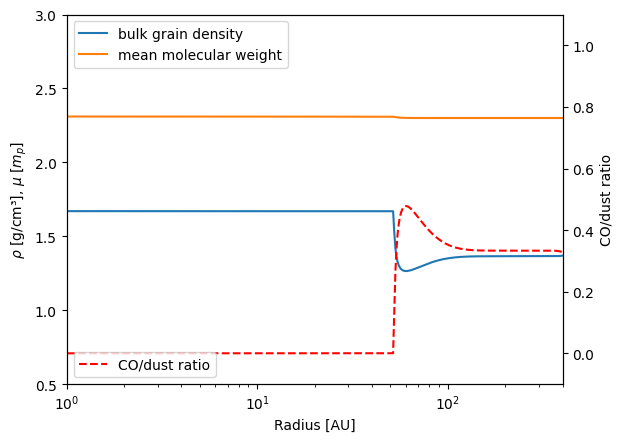

In [18]:
plt.figure()
plt.plot(sim_compo.grid.r/c.au,sim_compo.dust.rhos[:,1],label="bulk grain density")
plt.plot(sim_compo.grid.r/c.au,sim_compo.gas.mu/c.m_p,label="mean molecular weight")
plt.xscale("log")
plt.ylabel(r"$\rho$ [g/cm³], $\mu$ [$m_p$]")
plt.xlabel("Radius [AU]")
plt.ylim(0.5,3)
plt.legend(loc= "upper left")
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(sim_compo.grid.r/c.au,sim_compo.components.CO.dust.Sigma.sum(-1)/sim_compo.dust.Sigma.sum(-1),"--",color="r",label="CO/dust ratio")
plt.ylabel("CO/dust ratio")
plt.ylim(-0.1,1.1)
plt.xlim(1,400)
plt.legend(loc="lower left")
plt.show()

# Common pitfalls setting up simulations using components

When setting up a simulation with components, there are some common pitfalls to be aware of:

- for condensating/evaporating components, truncate the initial distribution at the same location as the dust disk 

- for each component `comp` you can check if it’s active in the gas or dust by checking `comp.gas_active` and `comp.dust._active`

- remember that the code always works in cgs units, so initialze the components accordingly (especially $\mu$)

- remember to initalize the relevant parameters for evaporation and condensation for hybrid components, 

- if using dust components, remember to add a "background component" as the field `sim.dust.Sigma` will be overwritten by the sum of the dust/gas components, i.e. `comp.gas.pars.nu` and `comp.gas.pars.Tsub`

- Remember that the gas disk always has one default component called `Default` that is only active in the gas and models the total evolution (if no other components are present)

- when using components, external source terms are defined on the component level, i.e. set `comp.gas.Sigma_dot` and `comp.dust..Sigma_dot` for external source terms

- remember tracer components can only have the "val" boundary condition